# Market and Network Analysis for AGM Delivery Network Optimization

AGM's growth strategy hinges on two key pillars: expanding our network of pickup locations and optimizing delivery routes. This approach is designed to widen our customer base, reduce delivery times, and improve overall customer satisfaction.

This analysis is structured around several core objectives:

- **Target Area Identification**: Pinpointing zip codes with the highest potential for growth, based on current customer distribution and demographic insights.
- **Geographical Analysis**: Leveraging spatial data to understand our operational environment and identify strategic areas for expansion.
- **Network Optimization**: Extracting graph-based and demographic features and applying a sequential selection algorithm for our pickup locations, ensuring maximum efficiency and coverage.
- **Impact Assessment**: Evaluating the potential impact of proposed changes on customer reach and service quality.

The `2.0-analysis.ipynb` notebook is designed to dissect these objectives through a series of structured analyses, each building on the data foundation laid by our `1.0-graph-creation.ipynb` notebook. By analyzing customer distribution, demographic trends, and network connectivity, we aim to unveil actionable insights that will guide AGM's strategic decisions.

# Setup

In [1]:
import neo4j
import csv

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mplPath

import os
import json

import psycopg2

import gmaps
import gmaps.geojson_geometries

from geographiclib.geodesic import Geodesic

In [ ]:
GEOJSON_FOLDER_PATH = '../data/external/geojson_data'
GEOJSON_BAY_AREA_PATH = '../data/external/geojson_data/bay_zip_geojson.json'
CENSUS_DATA_PATH = '../data/raw/census_data.csv'
GMAP_KEY_PATH = '../data/external/google_api_key.json' # Need to get this on your own

In [2]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)
cursor = connection.cursor()

In [3]:
# google api key
f = open(GMAP_KEY_PATH, 'r')
my_api_key = f.read()
f.close()

gmaps.configure(api_key=my_api_key)

In [4]:
def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# Target Area Analysis

## Calculate Target Zips

Identifying potential areas for expansion is critical to our strategy. This section focuses on calculating target zip codes where establishing new pickup locations could significantly enhance our service reach and operational efficiency. We leverage demographic data, current service areas, and customer distribution patterns to pinpoint these key areas.

We defined target zips as zip codes whithin a 5 miles radius from any of the stations in the database.

In [5]:
# get all the stations
rollback_before_flag = True
rollback_after_flag = True

query = """

select distinct station, latitude, longitude
from stations
order by station

"""

stations = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
stations.head()

,station,latitude,longitude
0,12th Street,37.803608,-122.272006
1,16th Street Mission,37.764847,-122.420042
2,19th Street,37.807869,-122.268980
3,24th Street Mission,37.752000,-122.418700
4,Antioch,37.996281,-121.783404


In [6]:
def my_calculate_distance(row, lat_ref, long_ref):
    "Given two points in (latitude, longitude) format, calculate the distance between them in miles"
    
    geod = Geodesic.WGS84

    g = geod.Inverse(lat_ref, long_ref, row['latitude'], row['longitude'])
    miles = g['s12'] / 1000 * 0.621371
    
    return miles

In [7]:
# calculate distance from each station to all CA zip codes
rollback_before_flag = True
rollback_after_flag = True

query = """

select distinct zip, latitude, longitude, population
from zip_codes where state='CA'
"""

df_0 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_0.head()

df_dist = pd.DataFrame()
for station in stations.station:

    df = df_0.copy()
    df['from_station'] = station
    df['distance'] = df.apply(
        my_calculate_distance,
        args=(stations[stations.station==station].latitude.values[0],
              stations[stations.station==station].longitude.values[0]), axis=1)
    df = df[df.distance<10]
    df_dist = pd.concat([df_dist, df])
df_dist

,zip,latitude,longitude,population,from_station,distance
8,94708,37.9027,-122.2620,11455,12th Street,6.856073
18,94115,37.7860,-122.4372,35004,12th Street,9.121974
100,94109,37.7952,-122.4222,56677,12th Street,8.239776
104,94707,37.8983,-122.2792,11916,12th Street,6.542580
190,94502,37.7368,-122.2406,14619,12th Street,4.917915
...,...,...,...,...,...,...
1702,94111,37.7989,-122.3984,3620,West Oakland,5.668014
1713,94158,37.7698,-122.3876,7291,West Oakland,5.611840
1718,94114,37.7580,-122.4354,34754,West Oakland,8.333133
1723,94103,37.7732,-122.4111,28735,West Oakland,6.714849


In [8]:
# get only nearest stations for each zip
df_nearest = df_dist.sort_values(by=['distance']).drop_duplicates(subset=['zip'], keep='first')
df_nearest

,zip,latitude,longitude,population,from_station,distance
1273,94544,37.6338,-122.0572,79235,South Hayward,0.038789
1041,94612,37.8088,-122.2691,16062,19th Street,0.064544
1502,94563,37.8797,-122.1846,19341,Orinda,0.099592
784,94104,37.7915,-122.4021,546,Montgomery Street,0.148188
1114,94110,37.7500,-122.4154,74161,24th Street Mission,0.227336
...,...,...,...,...,...,...
1168,94569,38.0351,-122.1924,205,North Concord,9.415080
668,94019,37.4647,-122.4162,20314,Millbrae,9.490898
1426,94070,37.4976,-122.2700,31049,Millbrae,9.551196
270,94939,37.9371,-122.5341,7108,Richmond,9.887097


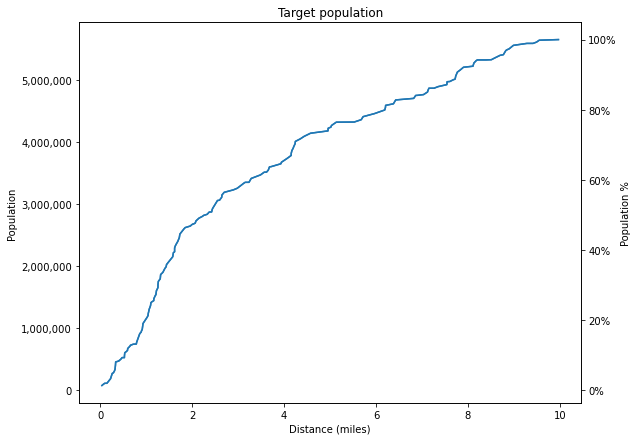

In [9]:
# plot reachable population by radious
df_nearest['cum_population'] = df_nearest.population.cumsum()
df_nearest['rel_cum_population'] = df_nearest.population.cumsum() /df_nearest.population.sum() 

fig, ax = plt.subplots(figsize=(9,7))
ax.plot(df_nearest['distance'], df_nearest['cum_population'])

ax2 = ax.twinx()
ax2.plot(df_nearest['distance'], df_nearest['rel_cum_population'])
ax.set_title('Target population')
ax.set_ylabel('Population')
ax2.set_ylabel('Population %')
ax.set_xlabel('Distance (miles)')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [10]:
# create 5 miles radius zips
zip_list = df_nearest[df_nearest.distance<=5].zip.unique()

In [11]:
# customer count by zip
rollback_before_flag = True
rollback_after_flag = True

query = """

select z.zip, z.latitude, z.longitude
from customers as cu
     join zip_codes as z
         on cu.zip = z.zip
where cu.closest_store_id = 1
order by 1,2

"""

df_customers = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

In [12]:
# add zips with current customes out of 5 mile range
total_zip_list = zip_list.tolist() + df_customers[df_customers.zip.isin(zip_list)==False].zip.unique().tolist()

## Median income by zip code

Economic factors play a significant role in determining the viability of potential expansion areas. Here, we analyze median income levels by zip code to assess the alignment with AGM's target market, ensuring that new locations cater to our primary customer demographic of affluent professionals.

This data will be used in the 'Network Optimization: Economic and demographic features" section

In [ ]:
# load census data
df_cens = pd.read_csv(CENSUS_DATA_PATH, usecols=[1,24], header=1, names=['zip','median_income'])
df_cens.zip = df_cens.zip.str[-5:]
df_cens.median_income = pd.to_numeric(df_cens.median_income, errors='coerce')
df_cens.head()

,zip,median_income
0,00601,14398.0
1,00602,16771.0
2,00603,15786.0
3,00606,14980.0
4,00610,20167.0


# Geographic Analysis

## Creating Geometries of Target Zips

Spatial analysis requires accurate geographical representations. In this section, we construct the geometries for our target zip codes, enabling detailed spatial analyses and mapping. This foundational step supports subsequent visualizations and geographical insights.

In [14]:
# create geo_json file
connection.rollback()

query = """

select lower(replace(state, ' ', '_')) || '_' || lower(replace(state_name, ' ', '_')) || '_geojson.json'
from
(
    select distinct z.state, st.state_name
    from customers cu
         join zip_codes z
             on cu.zip = z.zip
         join states st
             on z.state = st.state
) as a
order by 1


"""

cursor.execute(query)

connection.rollback()

rows = cursor.fetchall()

file_list = []

for row in rows:
    file_list.append(row[0])


customer_zip_geojson_file = open(GEOJSON_BAY_AREA_PATH, 'w')

customer_zip_geojson = {"type": "FeatureCollection", "features": []}

for file_name in file_list:
    
    directory_file_name = GEOJSON_FOLDER_PATH + file_name
    
    f = open(directory_file_name, 'r')
    geo = json.load(f)
    f.close()
    
    for fe in geo['features']:
        if fe['properties']['ZCTA5CE10'] in total_zip_list:
            customer_zip_geojson['features'].append(fe)
        
json.dump(customer_zip_geojson, customer_zip_geojson_file, indent=2)

customer_zip_geojson_file.close()
        
len(customer_zip_geojson['features'])

166

## Heatmap of current customers and target ZIPs

Visualizing the distribution of our current customer base against target zip codes offers valuable insights into potential areas of expansion. This section presents heatmaps that illustrate these distributions, highlighting areas with high customer density and those identified as strategic targets for expansion.

In [18]:
# current store
rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stores
where state='CA'

"""

df_stores = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_stores = df_stores[['city','latitude','longitude']].rename(columns={'city':'name'})
df_stores

,name,latitude,longitude
0,Berkeley,37.8555,-122.2604


In [19]:
# show on map
f = open(GEOJSON_BAY_AREA_PATH)
zip_geojson = json.load(f)
f.close()

fig = gmaps.figure(center=(37.72524180842726, -122.11975313700347), zoom_level=10, layout={
        'width': '900px',
        'height': '1000px'
})

# add zips polygon
geojson_layer = gmaps.geojson_layer(zip_geojson, fill_color='teal', fill_opacity=0.2)
fig.add_layer(geojson_layer)

# add heatmap of current customers
heatmap_layer = gmaps.heatmap_layer(df_customers[['latitude','longitude']])
fig.add_layer(heatmap_layer)

# add marker of current store
marker_layer = gmaps.symbol_layer(df_stores[['latitude','longitude']], fill_color='#7DF9FF', stroke_color='#1F51FF', scale=4, info_box_content='Berkeley store')
# heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 25
fig.add_layer(marker_layer)

# fig.add_layer(marker_layer)
fig.add_layer(gmaps.transit_layer())

fig

Figure(layout=FigureLayout(height='1000px', width='900px'))

## Heatmap of population in Bay Area
Understanding the broader population distribution is crucial for strategic planning. This heatmap provides a visual representation of population densities across the region, aiding in the identification of high-potential areas for new pickup locations.

In [20]:
# customer count by zip
rollback_before_flag = True
rollback_after_flag = True

query = """

select zip, latitude, longitude, population
from zip_codes
where zip::numeric in ({})
""".format(', '.join(total_zip_list))

df_zips = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_zips

,zip,latitude,longitude,population
0,94002,37.5135,-122.2991,27202
1,94010,37.5693,-122.3653,42730
2,94005,37.6887,-122.4080,4692
3,94014,37.6909,-122.4475,49515
4,94015,37.6812,-122.4805,64887
...,...,...,...,...
161,95113,37.3337,-121.8910,1939
162,94528,37.8456,-121.9507,307
163,94575,37.8419,-122.1105,1170
164,94128,37.6222,-122.3847,135


In [21]:
# weighted heatmap of population
f = open(GEOJSON_BAY_AREA_PATH)
zip_geojson = json.load(f)
f.close()

fig = gmaps.figure(center=(37.72524180842726, -122.11975313700347), zoom_level=10, layout={
        'width': '900px',
        'height': '1000px'
})

# add zips polygon
geojson_layer = gmaps.geojson_layer(zip_geojson, fill_color='teal', fill_opacity=0.2)
fig.add_layer(geojson_layer)

# add heatmap of current customers
heatmap_layer = gmaps.heatmap_layer(df_zips[['latitude', 'longitude']], weights=df_zips['population'])
fig.add_layer(heatmap_layer)
heatmap_layer.point_radius = 30

# add marker of current store
marker_layer = gmaps.symbol_layer(df_stores[['latitude','longitude']], fill_color='#7DF9FF', stroke_color='#1F51FF', scale=4, info_box_content='Berkeley store')
fig.add_layer(marker_layer)

# fig.add_layer(marker_layer)
fig.add_layer(gmaps.transit_layer())

fig

Figure(layout=FigureLayout(height='1000px', width='900px'))

## Population by mileage from Berkeley store

Analyzing the population within various distances from our Berkeley store helps evaluate our current service reach and identify underserved areas. This section delves into the demographics surrounding our flagship location, informing decisions on how to enhance local and regional coverage.

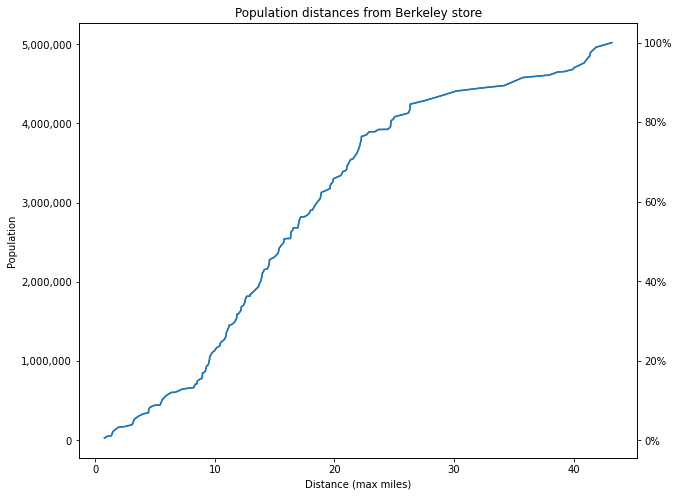

In [22]:
df_dist_bkl = df_zips.copy()
df_dist_bkl['distance'] = df_dist_bkl.apply(my_calculate_distance, args=(37.8555,-122.2604), axis=1)
df_dist_bkl.sort_values(by=['distance'], inplace=True)

# df_dist_bkl['customers'] = 1
df_dist_bkl['cum_population'] = df_dist_bkl.population.cumsum()
df_dist_bkl['rel_cum_population'] = df_dist_bkl.population.cumsum() /df_dist_bkl.population.sum() 

# plot distribution
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(df_dist_bkl['distance'], df_dist_bkl['cum_population'])

ax2 = ax.twinx()
ax2.plot(df_dist_bkl['distance'], df_dist_bkl['rel_cum_population'])
ax.set_title('Population distances from Berkeley store')
ax.set_ylabel('Population')
ax.set_xlabel('Distance (max miles)')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [19]:
df_dist_bkl[df_dist_bkl.distance<=5].population.sum() / df_dist_bkl.population.sum()

0.0834844661254041

### Current Distances from Berkeley to Customers

This analysis examines the distances between our Berkeley store and existing customers, providing insights into our delivery network's efficiency and identifying opportunities to reduce delivery times through strategic location placements.

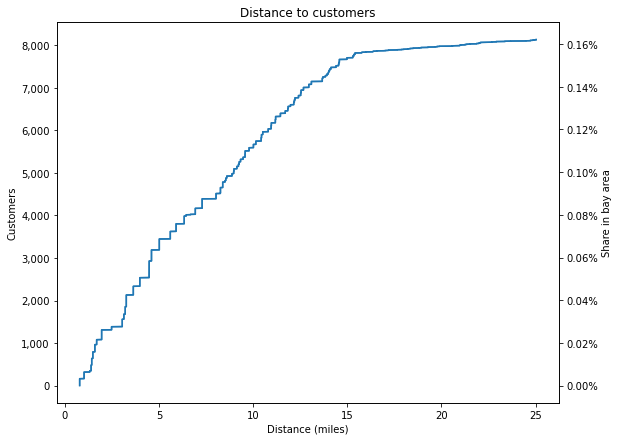

In [23]:
# calculate current distance from current berkeley store to customers
df_dist_bkl = df_customers.copy()
df_dist_bkl['distance'] = df_dist_bkl.apply(my_calculate_distance, args=(37.8555,-122.2604), axis=1)
df_dist_bkl.sort_values(by=['distance'], inplace=True)

df_dist_bkl['customers'] = 1
df_dist_bkl['cum_customers'] = df_dist_bkl.customers.cumsum()
df_dist_bkl['rel_cum_customers'] = df_dist_bkl.customers.cumsum() /df_zips.population.sum() 

# plot distribution
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(df_dist_bkl['distance'], df_dist_bkl['cum_customers'])

ax2 = ax.twinx()
ax2.plot(df_dist_bkl['distance'], df_dist_bkl['rel_cum_customers'])
ax.set_title('Distance to customers')
ax.set_ylabel('Customers')
ax2.set_ylabel('Share in bay area')
ax.set_xlabel('Distance (miles)')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2%}'))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

## Population Beyond Walking Distance

Focusing on the population beyond practical walking distance from existing locations highlights areas where new pickup locations could significantly improve accessibility for potential customers. This section analyses the distribution of population from the existing location to understand opportunities to expand the addressable population.

In [21]:
stations.head()

,station,latitude,longitude
0,12th Street,37.803608,-122.272006
1,16th Street Mission,37.764847,-122.420042
2,19th Street,37.807869,-122.268980
3,24th Street Mission,37.752000,-122.418700
4,Antioch,37.996281,-121.783404


In [24]:
def zip_contained(row):
    "Given the station (latitude, longitude) format, check which zip contains it"
    latitude = row[1]
    longitude = row[2]
    
    point = (longitude, latitude)
    for zip_code in total_zip_list:
        poly = [x for x in zip_geojson['features'] if x['properties']['ZCTA5CE10'] == zip_code][0]['geometry']['coordinates'][0]
        if len(np.array(poly).shape) == 3:
            for p in poly:
                polygon = mplPath.Path( np.array(p) )
                if polygon.contains_point(point):
                    return zip_code
        else:
            polygon = mplPath.Path( np.array(poly) )
            if polygon.contains_point(point):
                return zip_code
    return None

In [25]:
stations['zip'] = stations.apply(zip_contained, axis=1)
stations.zip = np.where(stations.station=='Dublin','94588',stations.zip)
stations.zip = np.where(stations.station=='Fremont','94536',stations.zip)
stations.zip = np.where(stations.station=='West Dublin','94568',stations.zip)
stations[stations.zip.isna()]

,station,latitude,longitude,zip


In [24]:
# calculate min distances from each zip to a station

df_dist = pd.DataFrame()
for station in stations.station:

    df = df_zips.copy()
    df['from_station'] = station
    df['distance'] = df.apply(
        my_calculate_distance,
        args=(stations[stations.station==station].latitude.values[0],
              stations[stations.station==station].longitude.values[0]), axis=1)
    df_dist = pd.concat([df_dist, df])
df_dist['contains_station'] = np.where(df_dist.zip.isin(stations.zip),1,0)

# get only nearest stations for each zip
df_dist = df_dist.sort_values(by=['distance']).drop_duplicates(subset=['zip'], keep='first')
df_dist['range'] = pd.cut(df_dist['distance'], [0, 0.5, 1,2,3,5, 1e10], labels=['walking range (0.5 miles)','0.5 to 1 mile', '1 to 2 miles', '2 to 3 miles', '3 to 5 miles','more than 5 miles'])
df_dist['range'] = np.where(df_dist.contains_station==1,'walking range (0.5 miles)',df_dist.range)
df_dist.head()

,zip,latitude,longitude,population,from_station,distance,contains_station,range
65,94544,37.6338,-122.0572,79235,South Hayward,0.038789,1,walking range (0.5 miles)
109,94612,37.8088,-122.2691,16062,19th Street,0.064544,1,walking range (0.5 miles)
76,94563,37.8797,-122.1846,19341,Orinda,0.099592,1,walking range (0.5 miles)
159,94104,37.7915,-122.4021,546,Montgomery Street,0.148188,1,walking range (0.5 miles)
19,94110,37.7500,-122.4154,74161,24th Street Mission,0.227336,1,walking range (0.5 miles)


In [25]:
# show on map
# f = open('../data/external/bay_zip_geojson.json')
# zip_geojson = json.load(f)
# f.close()

fig = gmaps.figure(center=(37.72524180842726, -122.11975313700347), zoom_level=10, layout={
        'width': '900px',
        'height': '1000px'
})

# add zips polygon

# create geojson
zips_geojson = {'type': 'FeatureCollection'}
zips_geojson['features'] = [x for x in zip_geojson['features'] if x['properties']['ZCTA5CE10'] in df_dist[df_dist.range=='walking range (0.5 miles)'].zip.tolist()]
geojson_layer = gmaps.geojson_layer(zips_geojson, fill_color='#228B22', fill_opacity=0.8)
fig.add_layer(geojson_layer)

zips_geojson = {'type': 'FeatureCollection'}
zips_geojson['features'] = [x for x in zip_geojson['features'] if x['properties']['ZCTA5CE10'] in df_dist[df_dist.range=='0.5 to 1 mile'].zip.tolist()]
geojson_layer = gmaps.geojson_layer(zips_geojson, fill_color='#228B22', fill_opacity=0.6)
fig.add_layer(geojson_layer)

zips_geojson = {'type': 'FeatureCollection'}
zips_geojson['features'] = [x for x in zip_geojson['features'] if x['properties']['ZCTA5CE10'] in df_dist[df_dist.range=='1 to 2 miles'].zip.tolist()]
geojson_layer = gmaps.geojson_layer(zips_geojson, fill_color='#FFA500', fill_opacity=0.4)
fig.add_layer(geojson_layer)

zips_geojson = {'type': 'FeatureCollection'}
zips_geojson['features'] = [x for x in zip_geojson['features'] if x['properties']['ZCTA5CE10'] in df_dist[df_dist.range=='2 to 3 miles'].zip.tolist()]
geojson_layer = gmaps.geojson_layer(zips_geojson, fill_color='#FFA500', fill_opacity=0.6)
fig.add_layer(geojson_layer)

zips_geojson = {'type': 'FeatureCollection'}
zips_geojson['features'] = [x for x in zip_geojson['features'] if x['properties']['ZCTA5CE10'] in df_dist[df_dist.range=='3 to 5 miles'].zip.tolist()]
geojson_layer = gmaps.geojson_layer(zips_geojson, fill_color='red', fill_opacity=0.3)
fig.add_layer(geojson_layer)

zips_geojson = {'type': 'FeatureCollection'}
zips_geojson['features'] = [x for x in zip_geojson['features'] if x['properties']['ZCTA5CE10'] in df_dist[df_dist.range=='more than 5 miles'].zip.tolist()]
geojson_layer = gmaps.geojson_layer(zips_geojson, fill_color='red', fill_opacity=0.5)
fig.add_layer(geojson_layer)

# add heatmap of current customers
# heatmap_layer = gmaps.heatmap_layer(df_customers[['latitude','longitude']])
# fig.add_layer(heatmap_layer)

# add marker of current stations
marker_layer = gmaps.symbol_layer(stations[['latitude','longitude']], fill_color='#7DF9FF', stroke_color='#1F51FF', scale=2, 
                                  info_box_content=stations['station'].tolist())
fig.add_layer(marker_layer)

# fig.add_layer(marker_layer)
# fig.add_layer(gmaps.transit_layer())

fig

Figure(layout=FigureLayout(height='1000px', width='900px'))

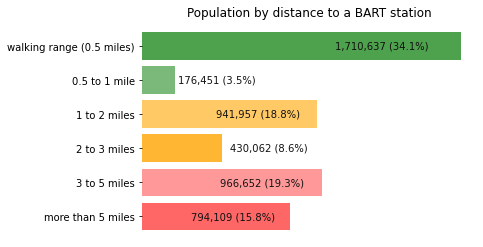

In [26]:
# bar chart of population by distance to bart station
fig, ax = plt.subplots(figsize=(6,4))

ax.barh(
    df_dist[df_dist.range=='more than 5 miles'].groupby('range').population.sum().index, 
    df_dist[df_dist.range=='more than 5 miles'].groupby('range').population.sum().reset_index().population,
    color='red', alpha=0.6)
ax.text(df_dist[df_dist.range=='more than 5 miles'].population.sum()*0.9, 'more than 5 miles',
        '{:,.0f} ({:.1%})'.format(df_dist[df_dist.range=='more than 5 miles'].population.sum(),
                                  df_dist[df_dist.range=='more than 5 miles'].population.sum() / df_dist.population.sum()),
        ha='right', va='center', color='#111')
ax.barh(
    df_dist[df_dist.range=='3 to 5 miles'].groupby('range').population.sum().index, 
    df_dist[df_dist.range=='3 to 5 miles'].groupby('range').population.sum().reset_index().population,
    color='red', alpha=0.4)
ax.text(df_dist[df_dist.range=='3 to 5 miles'].population.sum()*0.9, '3 to 5 miles',
        '{:,.0f} ({:.1%})'.format(df_dist[df_dist.range=='3 to 5 miles'].population.sum(),
                                  df_dist[df_dist.range=='3 to 5 miles'].population.sum() / df_dist.population.sum()),
        ha='right', va='center', color='#111')

ax.barh(
    df_dist[df_dist.range=='2 to 3 miles'].groupby('range').population.sum().index, 
    df_dist[df_dist.range=='2 to 3 miles'].groupby('range').population.sum().reset_index().population,
    color='#FFA500', alpha=0.8)
ax.text(df_dist[df_dist.range=='2 to 3 miles'].population.sum()*1.1, '2 to 3 miles',
        '{:,.0f} ({:.1%})'.format(df_dist[df_dist.range=='2 to 3 miles'].population.sum(),
                                  df_dist[df_dist.range=='2 to 3 miles'].population.sum() / df_dist.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    df_dist[df_dist.range=='1 to 2 miles'].groupby('range').population.sum().index, 
    df_dist[df_dist.range=='1 to 2 miles'].groupby('range').population.sum().reset_index().population,
    color='#FFA500', alpha=0.6)
ax.text(df_dist[df_dist.range=='1 to 2 miles'].population.sum()*0.9, '1 to 2 miles',
        '{:,.0f} ({:.1%})'.format(df_dist[df_dist.range=='1 to 2 miles'].population.sum(),
                                  df_dist[df_dist.range=='1 to 2 miles'].population.sum() / df_dist.population.sum()),
        ha='right', va='center', color='#111')

ax.barh(
    df_dist[df_dist.range=='0.5 to 1 mile'].groupby('range').population.sum().index, 
    df_dist[df_dist.range=='0.5 to 1 mile'].groupby('range').population.sum().reset_index().population,
    color='#228B22', alpha=0.6)
ax.text(df_dist[df_dist.range=='0.5 to 1 mile'].population.sum()*1.1, '0.5 to 1 mile',
        '{:,.0f} ({:.1%})'.format(df_dist[df_dist.range=='0.5 to 1 mile'].population.sum(),
                                  df_dist[df_dist.range=='0.5 to 1 mile'].population.sum() / df_dist.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    df_dist[df_dist.range=='walking range (0.5 miles)'].groupby('range').population.sum().index, 
    df_dist[df_dist.range=='walking range (0.5 miles)'].groupby('range').population.sum().reset_index().population,
    color='#228B22', alpha=0.8)
ax.text(df_dist[df_dist.range=='walking range (0.5 miles)'].population.sum() * 0.9, 'walking range (0.5 miles)',
        '{:,.0f} ({:.1%})'.format(df_dist[df_dist.range=='walking range (0.5 miles)'].population.sum(),
                                  df_dist[df_dist.range=='walking range (0.5 miles)'].population.sum() / df_dist.population.sum()),
        ha='right', va='center', color='#111')

# ax2 = ax.twinx()
# ax2.plot(df_dist_bkl['distance'], df_dist_bkl['rel_cum_population'])
ax.set_title('Population by distance to a BART station')
# ax.set_ylabel('Population')
# ax.set_xlabel('Distance (max miles)')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

# Network Optimization

## Simulate Population Covered by Number of Pickup Locations

Simulation plays a key role in strategic planning. Here, we simulate the impact of adding various numbers of pickup locations on service coverage, aiming to understand the potential reach and efficiency gains from our expansion strategy.

In [28]:
# current store distribution
stores_pull = df_stores.copy()
stores_simulation = stores_pull.copy()
stores_simulation

,name,latitude,longitude
0,Berkeley,37.8555,-122.2604


In [29]:
# get all the possible stations
stations_pull = stations[['station','latitude','longitude']].rename(columns={'station':'name'})
stations_pull.head()

,name,latitude,longitude
0,12th Street,37.803608,-122.272006
1,16th Street Mission,37.764847,-122.420042
2,19th Street,37.807869,-122.268980
3,24th Street Mission,37.752000,-122.418700
4,Antioch,37.996281,-121.783404


In [30]:
# save series to plot
covered_5 = []
covered_1 = []
covered_05 = []

In [31]:
# calculate base distances
df_sim = pd.DataFrame()

for store in stores_pull.name:
    print(store)
    df = df_zips.copy()
    df['from_store'] = store
    df['distance'] = df.apply(
        my_calculate_distance,
        args=(stores_pull[stores_pull.name==store].latitude.values[0],
              stores_pull[stores_pull.name==store].longitude.values[0]), axis=1)
#     df = df[df.distance<10]
    df_sim = pd.concat([df_sim, df])
df_sim = df_sim.sort_values(by=['distance']).drop_duplicates(subset=['zip'], keep='first')

# plot reachable population by radious
df_sim['cum_population'] = df_sim.population.cumsum()
df_sim['rel_cum_population'] = df_sim.population.cumsum() /df_sim.population.sum() 

# calculate AUC
df_sim['auc'] = (df_sim.population * df_sim.distance) / df_sim.population.sum()

# save series
x1 = df_sim['distance']
y1 = df_sim['cum_population']
y1r = df_sim['rel_cum_population']

# save % of population covered
covered_05.append(df_sim[df_sim.distance<=0.5].population.sum())
covered_1.append(df_sim[df_sim.distance<=1].population.sum())
covered_5.append(df_sim[df_sim.distance<=5].population.sum())

# print results
display(stores_simulation)
print('avg distance: {:,.1f}'.format(df_sim.auc.sum()))

stations_pull = stations_pull[stations_pull.name.isin(stores_simulation.name)==False]
stores_pull = stores_simulation.copy()

Berkeley


,name,latitude,longitude
0,Berkeley,37.8555,-122.2604


avg distance: 17.8


In [32]:
# simulate pickup locations
for s in range(stations.shape[0]):
    best_i = 0
    min_dist = df_sim.auc.sum()

    # select a new station
    for i in range(stations_pull.shape[0]):
        # select one extra station
        stores_simulation = pd.concat([stores_pull, stations_pull.iloc[i:i+1]])

        # calculate distances
        df_sim = pd.DataFrame()

        for store in stores_simulation.name:
            df = df_zips.copy()
            df['from_store'] = store
            df['distance'] = df.apply(
                my_calculate_distance,
                args=(stores_simulation[stores_simulation.name==store].latitude.values[0],
                      stores_simulation[stores_simulation.name==store].longitude.values[0]), axis=1)
        #     df = df[df.distance<10]
            df_sim = pd.concat([df_sim, df])
        df_sim = df_sim.sort_values(by=['distance']).drop_duplicates(subset=['zip'], keep='first')

        # plot reachable population by radious
        df_sim['cum_population'] = df_sim.population.cumsum()
        df_sim['rel_cum_population'] = df_sim.population.cumsum() /df_sim.population.sum() 

        # calculate AUC
        df_sim['auc'] = (df_sim.population * df_sim.distance) / df_sim.population.sum()

        if df_sim.auc.sum() < min_dist:
            min_dist = df_sim.auc.sum()
            best_i = i

    #_____ calculate with best_i
    stores_simulation = pd.concat([stores_pull, stations_pull.iloc[best_i:best_i+1]])

    # calculate distances
    df_sim = pd.DataFrame()

    for store in stores_simulation.name:
        df = df_zips.copy()
        df['from_store'] = store
        df['distance'] = df.apply(
            my_calculate_distance,
            args=(stores_simulation[stores_simulation.name==store].latitude.values[0],
                  stores_simulation[stores_simulation.name==store].longitude.values[0]), axis=1)
    #     df = df[df.distance<10]
        df_sim = pd.concat([df_sim, df])
    df_sim = df_sim.sort_values(by=['distance']).drop_duplicates(subset=['zip'], keep='first')

    # plot reachable population by radious
    df_sim['cum_population'] = df_sim.population.cumsum()
    df_sim['rel_cum_population'] = df_sim.population.cumsum() /df_sim.population.sum() 

    # calculate AUC
    df_sim['auc'] = (df_sim.population * df_sim.distance) / df_sim.population.sum()

    # save series
    x2 = df_sim['distance']
    y2 = df_sim['cum_population']
    y2r = df_sim['rel_cum_population']

    # save % of population covered
    covered_05.append(df_sim[df_sim.distance<=0.5].population.sum())
    covered_1.append(df_sim[df_sim.distance<=1].population.sum())
    covered_5.append(df_sim[df_sim.distance<=5].population.sum())
    
    display(stores_simulation.tail(1))
    print('avg distance: {:,.1f}'.format(df_sim.auc.sum()))
    
    print('Nº of pickup locations: {:,.0f}'.format(stores_simulation.shape[0]))
    print('% covered 5 miles: {:,.1%}, {:,.0f}'.format(
        df_sim[df_sim.distance<=5].population.sum()/df_zips.population.sum(),
         df_sim[df_sim.distance<=5].population.sum()))
    print('% covered 1 miles: {:,.1%}, {:,.0f}'.format(
        df_sim[df_sim.distance<=1].population.sum()/df_zips.population.sum(),
         df_sim[df_sim.distance<=1].population.sum()))

    stations_pull = stations_pull[stations_pull.name.isin(stores_simulation.name)==False]
    stores_pull = stores_simulation.copy()

,name,latitude,longitude
20,Fremont,37.557489,-121.97662


avg distance: 12.3
Nº of pickup locations: 2
% covered 5 miles: 14.6%, 734,726
% covered 1 miles: 0.6%, 29,190


,name,latitude,longitude
22,Glen Park,37.733118,-122.433808


avg distance: 9.9
Nº of pickup locations: 3
% covered 5 miles: 33.8%, 1,694,273
% covered 1 miles: 1.2%, 59,092


,name,latitude,longitude
13,Concord,37.973745,-122.029127


avg distance: 8.3
Nº of pickup locations: 4
% covered 5 miles: 37.5%, 1,882,323
% covered 1 miles: 1.2%, 59,092


,name,latitude,longitude
8,Berryessa,37.368361,-121.874655


avg distance: 7.1
Nº of pickup locations: 5
% covered 5 miles: 46.3%, 2,322,151
% covered 1 miles: 1.7%, 87,818


,name,latitude,longitude
9,Castro Valley,37.690748,-122.075679


avg distance: 6.3
Nº of pickup locations: 6
% covered 5 miles: 52.5%, 2,634,384
% covered 1 miles: 1.7%, 87,818


,name,latitude,longitude
27,Millbrae,37.6003,-122.3867


avg distance: 5.8
Nº of pickup locations: 7
% covered 5 miles: 56.7%, 2,846,094
% covered 1 miles: 2.2%, 110,528


,name,latitude,longitude
38,Richmond,37.936811,-122.353095


avg distance: 5.2
Nº of pickup locations: 8
% covered 5 miles: 60.7%, 3,048,099
% covered 1 miles: 2.2%, 110,528


,name,latitude,longitude
4,Antioch,37.996281,-121.783404


avg distance: 4.9
Nº of pickup locations: 9
% covered 5 miles: 63.8%, 3,200,731
% covered 1 miles: 2.2%, 110,528


,name,latitude,longitude
16,Dublin,37.701663,-121.899232


avg distance: 4.6
Nº of pickup locations: 10
% covered 5 miles: 67.3%, 3,379,436
% covered 1 miles: 2.2%, 110,528


,name,latitude,longitude
21,Fruitvale,37.7748,-122.2241


avg distance: 4.4
Nº of pickup locations: 11
% covered 5 miles: 72.2%, 3,624,050
% covered 1 miles: 3.2%, 162,827


,name,latitude,longitude
10,Civic Center,37.779861,-122.413498


avg distance: 4.2
Nº of pickup locations: 12
% covered 5 miles: 72.8%, 3,653,641
% covered 1 miles: 4.7%, 237,179


,name,latitude,longitude
46,Walnut Creek,37.905724,-122.067332


avg distance: 4.1
Nº of pickup locations: 13
% covered 5 miles: 75.0%, 3,766,636
% covered 1 miles: 5.2%, 259,913


,name,latitude,longitude
35,Pittsburg Center,38.018227,-121.890178


avg distance: 4.0
Nº of pickup locations: 14
% covered 5 miles: 76.9%, 3,862,717
% covered 1 miles: 7.1%, 355,994


,name,latitude,longitude
43,South Hayward,37.634362,-122.057172


avg distance: 3.9
Nº of pickup locations: 15
% covered 5 miles: 77.6%, 3,895,242
% covered 1 miles: 8.7%, 435,229


,name,latitude,longitude
41,San Leandro,37.721764,-122.160684


avg distance: 3.8
Nº of pickup locations: 16
% covered 5 miles: 79.0%, 3,967,638
% covered 1 miles: 9.6%, 483,317


,name,latitude,longitude
44,South San Francisco,37.664264,-122.444043


avg distance: 3.7
Nº of pickup locations: 17
% covered 5 miles: 79.8%, 4,006,703
% covered 1 miles: 9.6%, 483,317


,name,latitude,longitude
47,Warm Springs,37.503,-121.94


avg distance: 3.6
Nº of pickup locations: 18
% covered 5 miles: 79.8%, 4,006,703
% covered 1 miles: 9.6%, 483,317


,name,latitude,longitude
28,Milpitas,37.410278,-121.891111


avg distance: 3.6
Nº of pickup locations: 19
% covered 5 miles: 82.4%, 4,135,753
% covered 1 miles: 9.6%, 483,317


,name,latitude,longitude
25,Lake Merritt,37.797773,-122.266588


avg distance: 3.5
Nº of pickup locations: 20
% covered 5 miles: 82.4%, 4,135,753
% covered 1 miles: 9.9%, 499,379


,name,latitude,longitude
45,Union City,37.590746,-122.017282


avg distance: 3.5
Nº of pickup locations: 21
% covered 5 miles: 83.2%, 4,174,141
% covered 1 miles: 11.4%, 573,980


,name,latitude,longitude
31,North Concord,38.003273,-122.024599


avg distance: 3.5
Nº of pickup locations: 22
% covered 5 miles: 83.2%, 4,174,141
% covered 1 miles: 11.4%, 573,980


,name,latitude,longitude
12,Colma,37.684722,-122.466111


avg distance: 3.4
Nº of pickup locations: 23
% covered 5 miles: 83.2%, 4,174,141
% covered 1 miles: 12.7%, 638,867


,name,latitude,longitude
3,24th Street Mission,37.752,-122.4187


avg distance: 3.4
Nº of pickup locations: 24
% covered 5 miles: 83.2%, 4,174,141
% covered 1 miles: 14.2%, 713,028


,name,latitude,longitude
7,Bay Fair,37.697,-122.1265


avg distance: 3.4
Nº of pickup locations: 25
% covered 5 miles: 83.2%, 4,174,141
% covered 1 miles: 15.0%, 754,087


,name,latitude,longitude
18,El Cerrito Plaza,37.902694,-122.298968


avg distance: 3.3
Nº of pickup locations: 26
% covered 5 miles: 83.2%, 4,174,141
% covered 1 miles: 15.4%, 775,127


,name,latitude,longitude
24,Lafayette,37.893186,-122.124614


avg distance: 3.3
Nº of pickup locations: 27
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 16.0%, 804,766


,name,latitude,longitude
6,Balboa Park,37.721667,-122.4475


avg distance: 3.3
Nº of pickup locations: 28
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 17.7%, 889,932


,name,latitude,longitude
40,San Bruno,37.6383,-122.4165


avg distance: 3.3
Nº of pickup locations: 29
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 17.7%, 889,932


,name,latitude,longitude
33,Orinda,37.878427,-122.18374


avg distance: 3.3
Nº of pickup locations: 30
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 18.1%, 909,273


,name,latitude,longitude
17,El Cerrito del Norte,37.925183,-122.316939


avg distance: 3.3
Nº of pickup locations: 31
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 18.1%, 909,273


,name,latitude,longitude
23,Hayward,37.6697,-122.087


avg distance: 3.2
Nº of pickup locations: 32
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 19.4%, 975,329


,name,latitude,longitude
11,Coliseum,37.753611,-122.196944


avg distance: 3.2
Nº of pickup locations: 33
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 19.4%, 975,329


,name,latitude,longitude
26,MacArthur,37.82826,-122.267275


avg distance: 3.2
Nº of pickup locations: 34
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 19.9%, 998,140


,name,latitude,longitude
49,West Oakland,37.8049,-122.2951


avg distance: 3.2
Nº of pickup locations: 35
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 20.4%, 1,024,394


,name,latitude,longitude
15,Downtown Berkeley,37.869799,-122.268197


avg distance: 3.2
Nº of pickup locations: 36
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 21.1%, 1,061,042


,name,latitude,longitude
1,16th Street Mission,37.764847,-122.420042


avg distance: 3.2
Nº of pickup locations: 37
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 21.8%, 1,095,796


,name,latitude,longitude
19,Embarcadero,37.793056,-122.397222


avg distance: 3.2
Nº of pickup locations: 38
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 22.1%, 1,109,117


,name,latitude,longitude
39,Rockridge,37.844452,-122.252083


avg distance: 3.2
Nº of pickup locations: 39
% covered 5 miles: 83.5%, 4,190,657
% covered 1 miles: 22.4%, 1,126,158


,name,latitude,longitude
48,West Dublin,37.699726,-121.928273


avg distance: 3.2
Nº of pickup locations: 40
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.4%, 1,126,158


,name,latitude,longitude
36,Pleasant Hill,37.928399,-122.055992


avg distance: 3.2
Nº of pickup locations: 41
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.4%, 1,126,158


,name,latitude,longitude
14,Daly City,37.706224,-122.468934


avg distance: 3.2
Nº of pickup locations: 42
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.4%, 1,126,158


,name,latitude,longitude
2,19th Street,37.807869,-122.26898


avg distance: 3.2
Nº of pickup locations: 43
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.4%, 1,126,158


,name,latitude,longitude
30,North Berkeley,37.873915,-122.282552


avg distance: 3.2
Nº of pickup locations: 44
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.8%, 1,143,250


,name,latitude,longitude
32,OAK,37.7132,-122.2122


avg distance: 3.2
Nº of pickup locations: 45
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.8%, 1,143,250


,name,latitude,longitude
37,Powell Street,37.784,-122.408


avg distance: 3.2
Nº of pickup locations: 46
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.8%, 1,143,250


,name,latitude,longitude
29,Montgomery Street,37.789355,-122.401942


avg distance: 3.2
Nº of pickup locations: 47
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.8%, 1,143,250


,name,latitude,longitude
42,SFO,37.6164,-122.391


avg distance: 3.2
Nº of pickup locations: 48
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.8%, 1,143,385


,name,latitude,longitude
0,12th Street,37.803608,-122.272006


avg distance: 3.2
Nº of pickup locations: 49
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.8%, 1,143,385


,name,latitude,longitude
5,Ashby,37.853068,-122.269957


avg distance: 3.2
Nº of pickup locations: 50
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.8%, 1,143,385


,name,latitude,longitude
34,Pittsburg,38.018869,-121.944208


avg distance: 3.2
Nº of pickup locations: 51
% covered 5 miles: 84.2%, 4,225,759
% covered 1 miles: 22.8%, 1,143,385


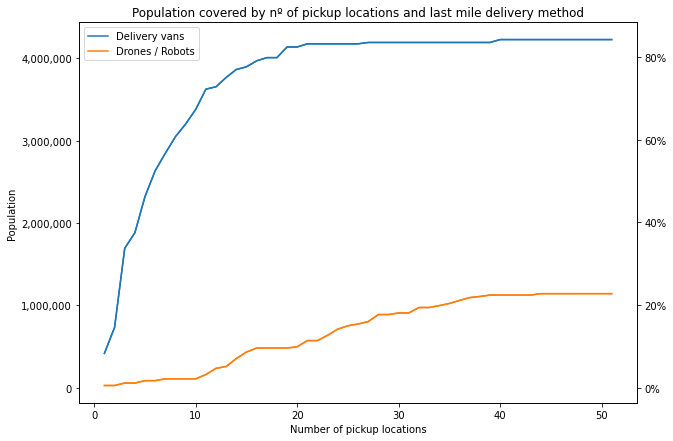

In [34]:
# plot results
fig, ax = plt.subplots(figsize=(10,7))

n_stores = range(1, len(covered_5)+1)
ax.plot(n_stores, covered_5, label='Delivery vans')
ax.plot(n_stores, covered_1, label='Drones / Robots')
# ax.plot(n_stores, covered_05, label='0.5 mile')

ax2 = ax.twinx()

ax2.plot(n_stores, np.array(covered_5)/df_sim.population.sum())
ax2.plot(n_stores, np.array(covered_1)/df_sim.population.sum())
ax.set_title('Population covered by nº of pickup locations and last mile delivery method'.format(df_sim.auc.sum()))
ax.set_ylabel('Population')
ax.set_xlabel('Number of pickup locations')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend()
plt.show()

In [ ]:
# # plot
# fig, ax = plt.subplots(figsize=(12,8))

# ax.plot(x1, y1, label='Berkeley')
# ax.plot(x2, y2, label='Add {}'.format(stores_simulation.name.values[1]))
# ax.plot(x3, y3, label='Add {}'.format(stores_simulation.name.values[2]))
# ax.plot(x4, y4, label='Add {}'.format(stores_simulation.name.values[3]))
# ax.plot(x5, y5, label='Add {}'.format(stores_simulation.name.values[4]))
# ax.plot(x6, y6, label='Add {}'.format(stores_simulation.name.values[5]))
# ax.plot(x7, y7, label='Add {}'.format(stores_simulation.name.values[6]))

# # ax2 = ax.twinx()
# # ax2.plot(df_sim['distance'], df_sim['rel_cum_population'])
# ax.set_title('Target population, avg distance: {:,.1f}'.format(df_sim.auc.sum()))
# ax.set_ylabel('Population')
# # ax2.set_ylabel('Population %')
# ax.set_xlabel('Distance (miles)')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# plt.legend()
# plt.show()

## Extract features for each station

Each station in our network possesses unique features that can influence its performance and role within the network. We extract and analyze these features, including location, connectivity, and demographic characteristics, to inform our optimization strategies.


### Graph-based features

Leveraging graph algorithms allows us to optimize the delivery network's design and operation. This section outlines the application of these algorithms to model delivery routes, simulate efficient networks, and identify optimal locations for new pickup points. Here we focus on extracting betweenness centrality features as well as the number of lines passing through each station.

In [30]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [31]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","w205"))
session = driver.session(database="neo4j")

In [32]:
query = "CALL gds.graph.drop('ds_graph', false)"
session.run(query)

query = "CALL gds.graph.create('ds_graph', 'Station', 'LINK', {relationshipProperties: 'weight'})"
session.run(query)

In [33]:
query = """

CALL gds.betweenness.stream('ds_graph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as betweenness
ORDER BY betweenness DESC

"""

df_betw = my_neo4j_run_query_pandas(query)
df_betw = df_betw[df_betw.name.str.contains('(?:arrive|depart)')==False]
df_betw.head(10)

,name,betweenness
0,yellow MacArthur,5999.809223
1,yellow Rockridge,5509.000000
2,orange Lake Merritt,5155.831877
3,orange 12th Street,5139.715461
4,yellow Orinda,4997.000000
5,yellow 19th Street,4820.250748
6,orange Fruitvale,4641.959661
7,yellow Lafayette,4469.000000
8,yellow 12th Street,4423.507563
9,orange Coliseum,4306.942363


In [34]:
# get the maximum betweenness for each station
df_betw['station'] = df_betw.name.str.split(' ', 1).str[1]
df_betw = df_betw.groupby('station').betweenness.max().reset_index().sort_values(by='betweenness', ascending=False)
df_betw.head(10)

,station,betweenness
26,MacArthur,5999.809223
39,Rockridge,5509.000000
25,Lake Merritt,5155.831877
0,12th Street,5139.715461
33,Orinda,4997.000000
2,19th Street,4820.250748
21,Fruitvale,4641.959661
24,Lafayette,4469.000000
11,Coliseum,4306.942363
49,West Oakland,3942.135136


In [184]:
# add numer of lines converging in each station
rollback_before_flag = True
rollback_after_flag = True

query = """

select distinct line, station
from lines
"""

df_lines = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_lines = df_lines.groupby('station').line.count().rename('n_lines').reset_index()

df_scores = df_betw.merge(df_lines, how='left', on=['station'])

# df_scores['attrib_population'] = np.nan
# df_scores['attrib_income'] = np.nan
df_scores.head()

,station,betweenness,n_lines
0,MacArthur,5999.809223,3
1,Rockridge,5509.000000,1
2,Lake Merritt,5155.831877,3
3,12th Street,5139.715461,3
4,Orinda,4997.000000,1


### Weighted population and income features
We also consider the population that would be addressed by each station, as well as the income of the population within the catchment area of each station. Incorporating weighted considerations of population density and income levels by ZIP code enables a nuanced approach to network optimization. This analysis prioritizes areas that not only have high population densities but also align with AGM's target demographic profile.


In [232]:
# stations dataframe
df = stations[['station','latitude','longitude']]
df.columns = ['station','station_lat','station_lon']
df['a'] = 1

# add all target zips to each station
df_zips['a'] = 1
df = df.merge(df_zips, how='left', on='a')
df_zips.drop(columns=['a'], inplace=True)
df.drop(columns=['a'], inplace=True)

df.columns = ['station','station_lat','station_lon', 'zip','zip_lat','zip_lon','population']

# add median income
df = df.merge(df_cens, how='left',on=['zip'])
df.head()

# calculate distance from stations to all zips
def my_calculate_distance_df(row):
    "Given two points in (latitude, longitude) format, calculate the distance between them in miles"
    
    geod = Geodesic.WGS84

    g = geod.Inverse(row['zip_lat'], row['zip_lon'], row['station_lat'], row['station_lon'])
    miles = g['s12'] / 1000 * 0.621371
    
    return miles
df['distance'] = df.apply(my_calculate_distance_df, axis=1)
df_station_zip_distance = df.copy()
df = df[df.distance<=5]

# # calculate weighted population and income
df['population_weighted'] = df.population / df.distance
df['income_weighted'] = df.median_income * df.population_weighted / df.groupby('station').population_weighted.transform('sum')

df = df.groupby('station', as_index=False).agg({
    'population':'sum',
    'population_weighted':'sum',
    'income_weighted':'sum'})

# df.head()
df[df.station=='Fremont']

,station,population,population_weighted,income_weighted
20,Fremont,315645,130613.653216,133465.19439


In [186]:
# add to df_scores
df_scores = df_scores.merge(df, how='left', on=['station'])
df_scores.head(10)

,station,betweenness,n_lines,population,population_weighted,income_weighted
0,MacArthur,5999.809223,3,504427,232564.640881,92237.856049
1,Rockridge,5509.000000,1,483072,204386.955056,104899.631973
2,Lake Merritt,5155.831877,3,464779,204650.505516,86056.007619
3,12th Street,5139.715461,3,474350,216478.212043,83922.166005
4,Orinda,4997.000000,1,191812,238595.073825,212903.70656
5,19th Street,4820.250748,3,471471,426365.784799,71970.974979
6,Fruitvale,4641.959661,3,465898,293292.435978,69395.373616
7,Lafayette,4469.000000,1,163256,89993.627054,167024.164046
8,Coliseum,4306.942363,4,416742,161917.482745,72117.356437
9,West Oakland,3942.135136,4,407075,205408.75502,75712.134221


In [188]:
# Normalise the data
df_scores.population_weighted = np.log(df_scores.population_weighted+1)

from sklearn.preprocessing import MinMaxScaler
for col in ['betweenness','n_lines','population_weighted','income_weighted']:
    df_scores[col+'_norm'] = MinMaxScaler().fit_transform(np.array(df_scores[col]).reshape(-1,1))*100

# modify weights (for use as scores)
df_scores.betweenness_norm = df_scores.betweenness_norm * 0.8 # reduce the impact of n_lines in the final score
df_scores.n_lines_norm = df_scores.n_lines_norm * 0.5 # reduce the impact of n_lines in the final score

df_scores.head()

,station,betweenness,n_lines,population,population_weighted,income_weighted,betweenness_norm,n_lines_norm,population_weighted_norm,income_weighted_norm
0,MacArthur,5999.809223,3,504427,12.356928,92237.856049,80.000000,33.333333,37.627249,15.917182
1,Rockridge,5509.000000,1,483072,12.227775,104899.631973,73.253477,0.000000,33.969803,24.740207
2,Lake Merritt,5155.831877,3,464779,12.229064,86056.007619,68.398930,33.333333,34.006295,11.609524
3,12th Street,5139.715461,3,474350,12.28525,83922.166005,68.177398,33.333333,35.597414,10.122612
4,Orinda,4997.000000,1,191812,12.382527,212903.70656,66.215672,0.000000,38.352197,100.000000


In [189]:
# calculate the score
df_scores['score'] = df_scores.betweenness_norm + df_scores.n_lines_norm + df_scores.population_weighted_norm + df_scores.income_weighted_norm
df_scores.sort_values(by='score', ascending=False, inplace=True)
df_scores.head(10)

,station,betweenness,n_lines,population,population_weighted,income_weighted,betweenness_norm,n_lines_norm,population_weighted_norm,income_weighted_norm,score
4,Orinda,4997.000000,1,191812,12.382527,212903.70656,66.215672,0.000000,38.352197,100.000000,204.567869
19,24th Street Mission,2829.403538,4,921187,13.409873,129453.333746,36.420513,50.000000,67.445390,41.849807,195.715710
18,16th Street Mission,3010.550494,4,870044,13.010501,121128.66935,38.910507,50.000000,56.135643,36.048984,181.095134
24,Balboa Park,2437.338289,4,912661,13.316151,112999.850386,31.031297,50.000000,64.791292,30.384631,176.207219
17,Civic Center,3180.147417,4,838556,13.120778,104451.214472,41.241738,50.000000,59.258576,24.427739,174.928052
22,Glen Park,2637.248955,4,959547,12.948668,120934.535015,33.779211,50.000000,54.384607,35.913706,174.077524
16,Powell Street,3339.483800,4,790733,12.922575,107487.186417,43.431930,50.000000,53.645698,26.543276,173.620904
13,Montgomery Street,3492.402727,4,599641,12.734194,103133.369052,45.533910,50.000000,48.310961,23.509433,167.354303
0,MacArthur,5999.809223,3,504427,12.356928,92237.856049,80.000000,33.333333,37.627249,15.917182,166.877764
11,Embarcadero,3648.987775,4,535747,12.597192,100311.71348,47.686283,50.000000,44.431230,21.543237,163.660749


## Simulate Station Selection

Choosing the right locations for new pickup stations is a complex decision. This section employs simulation techniques to model the selection process, considering various factors such as population coverage, demographic alignment, and geographical distribution. We use a sequential selection algorithm to optimize for the best pickup locations while ensuring a geographically well-distributed network of stations:

1) Select the first available station with the highest score as Pickup location
2) Remove stations within a 5 miles range  
3) Repeat

In [190]:
# pull of available stores
stores_pull = df_scores[['station']].merge(stations, how='left',on=['station'])
display(stores_pull.head())

# df for selected 
df_select = pd.DataFrame()

,station,latitude,longitude,zip
0,Orinda,37.878427,-122.183740,94563
1,24th Street Mission,37.752000,-122.418700,94110
2,16th Street Mission,37.764847,-122.420042,94110
3,Balboa Park,37.721667,-122.447500,94112
4,Civic Center,37.779861,-122.413498,94102


In [199]:
# select the best pickup locations
df_select = pd.concat([df_select, stores_pull.iloc[0:1]])
display(df_select)

# remove from pull list
stores_pull = stores_pull[stores_pull.station.isin(df_select.station)==False]

# remove stations within a 5 mile range from selected station
stores_pull['distance'] = stores_pull.apply(
    my_calculate_distance,
    args=(df_select.latitude.values[-1],df_select.longitude.values[-1]), axis=1)

stores_pull = stores_pull[stores_pull.distance>5].drop(columns=['distance'])

,station,latitude,longitude,zip
0,Orinda,37.878427,-122.183740,94563
1,24th Street Mission,37.752000,-122.418700,94110
8,MacArthur,37.828260,-122.267275,94609
10,South Hayward,37.634362,-122.057172,94544
18,Coliseum,37.753611,-122.196944,94621
21,Bay Fair,37.697000,-122.126500,94580
24,Colma,37.684722,-122.466111,94014
25,Fremont,37.557489,-121.976620,94536
27,Walnut Creek,37.905724,-122.067332,94596


In [229]:
df_scores.head()

# normalize score 0-100
df_select.score = df_select.score / (df_select.betweenness_norm.max() + df_select.n_lines_norm.max() + df_select.population_weighted_norm.max() + df_select.income_weighted_norm.max())

In [230]:
df_select = pd.concat([df_stores,df_select.rename(columns={'station':'name'})]).merge(df_scores.rename(columns={'station':'name'}), how='left', on=['name'])
df_select

,name,latitude,longitude,zip,betweenness,n_lines,population,population_weighted,income_weighted,betweenness_norm,n_lines_norm,population_weighted_norm,income_weighted_norm,score
0,Berkeley,37.855500,-122.260400,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN
1,Orinda,37.878427,-122.183740,94563,4997.000000,1.0,191812,12.382527,212903.70656,66.215672,0.000000,38.352197,100.000000,0.619903
2,24th Street Mission,37.752000,-122.418700,94110,2829.403538,4.0,921187,13.409873,129453.333746,36.420513,50.000000,67.445390,41.849807,0.593078
3,MacArthur,37.828260,-122.267275,94609,5999.809223,3.0,504427,12.356928,92237.856049,80.000000,33.333333,37.627249,15.917182,0.505690
4,South Hayward,37.634362,-122.057172,94544,2432.671929,2.0,266634,14.559449,90035.973498,30.967154,16.666667,100.000000,14.382858,0.490960
5,Coliseum,37.753611,-122.196944,94621,4306.942363,4.0,416742,11.994848,72117.356437,56.730338,50.000000,27.373593,1.896742,0.412123
6,Bay Fair,37.697000,-122.126500,94580,3348.740208,3.0,329162,12.058539,81764.277332,43.559166,33.333333,29.177236,8.618945,0.347541
7,Colma,37.684722,-122.466111,94014,1873.266460,2.0,488088,12.360334,105157.62384,23.277727,16.666667,37.723709,24.919982,0.310873
8,Fremont,37.557489,-121.976620,94536,1592.704368,2.0,315645,11.780007,133465.19439,19.421201,16.666667,21.289537,44.645366,0.309160
9,Walnut Creek,37.905724,-122.067332,94596,3925.000000,1.0,199253,11.329765,121050.50813,51.480268,0.000000,8.539228,35.994519,0.290952


In [399]:
# weighted heatmap of population
f = open(GEOJSON_BAY_AREA_PATH)
zip_geojson = json.load(f)
f.close()

fig = gmaps.figure(center=(37.72524180842726, -122.11975313700347), zoom_level=10, layout={
        'width': '900px',
        'height': '1000px'
})

# add zips polygon
geojson_layer = gmaps.geojson_layer(zip_geojson, fill_color='teal', fill_opacity=0.2)
fig.add_layer(geojson_layer)

# grey colors to zips out of 5-mile range (or separate figure)

# add heatmap of current customers
heatmap_layer = gmaps.heatmap_layer(df_zips[['latitude', 'longitude']], weights=df_zips['population'])
fig.add_layer(heatmap_layer)
heatmap_layer.point_radius = 30

# add marker of current store
marker_layer = gmaps.symbol_layer(df_select[['latitude','longitude']], fill_color='#7DF9FF', stroke_color='#1F51FF', scale=4, 
                                  info_box_content=df_select.name.tolist())
fig.add_layer(marker_layer)

# fig.add_layer(marker_layer)
fig.add_layer(gmaps.transit_layer())

fig

Figure(layout=FigureLayout(height='1000px', width='900px'))

In [400]:
# weighted heatmap of population
f = open(GEOJSON_BAY_AREA_PATH)
zip_geojson = json.load(f)
f.close()

fig = gmaps.figure(center=(37.72524180842726, -122.11975313700347), zoom_level=10, layout={
        'width': '900px',
        'height': '1000px'
})

# add zips polygon
zips_geojson = {'type': 'FeatureCollection'}
zips_geojson['features'] = [x for x in zip_geojson['features'] if x['properties']['ZCTA5CE10'] in zips_5]
geojson_layer = gmaps.geojson_layer(zips_geojson, fill_color='teal', fill_opacity=0.2)
fig.add_layer(geojson_layer)

# grey colors to zips out of 5-mile range (or separate figure)

# add heatmap of current customers
heatmap_layer = gmaps.heatmap_layer(df_zips[['latitude', 'longitude']], weights=df_zips['population'])
fig.add_layer(heatmap_layer)
heatmap_layer.point_radius = 30

# add marker of current store
marker_layer = gmaps.symbol_layer(df_select[['latitude','longitude']], fill_color='#7DF9FF', stroke_color='#1F51FF', scale=4, 
                                  info_box_content=df_select.name.tolist())
fig.add_layer(marker_layer)

# fig.add_layer(marker_layer)
fig.add_layer(gmaps.transit_layer())

fig

Figure(layout=FigureLayout(height='1000px', width='900px'))

In [241]:
# gets zips within 5 mile from selected stations
df_station_zip_distance = df_station_zip_distance[df_station_zip_distance.station.isin(df_select.name)]
zips_5 = df_station_zip_distance[df_station_zip_distance.distance<=5].zip.unique().tolist()
zips_not_5 = df_station_zip_distance[(df_station_zip_distance.distance>5)&(df_station_zip_distance.zip.isin(zips_5)==False)].zip.unique().tolist()

In [249]:
# weighted heatmap of population
f = open(GEOJSON_BAY_AREA_PATH)
zip_geojson = json.load(f)
f.close()

fig = gmaps.figure(center=(37.72524180842726, -122.11975313700347), zoom_level=10, layout={
        'width': '900px',
        'height': '1000px'
})

# add zips polygon
zips_geojson = {'type': 'FeatureCollection'}
zips_geojson['features'] = [x for x in zip_geojson['features'] if x['properties']['ZCTA5CE10'] in zips_5]
geojson_layer = gmaps.geojson_layer(zips_geojson, fill_color='teal', fill_opacity=0.6)
fig.add_layer(geojson_layer)

zips_geojson = {'type': 'FeatureCollection'}
zips_geojson['features'] = [x for x in zip_geojson['features'] if x['properties']['ZCTA5CE10'] in zips_not_5]
geojson_layer = gmaps.geojson_layer(zips_geojson, fill_color='gray', fill_opacity=0.6)
fig.add_layer(geojson_layer)

# grey colors to zips out of 5-mile range (or separate figure)

# add heatmap of population
# heatmap_layer = gmaps.heatmap_layer(df_zips[['latitude', 'longitude']], weights=df_zips['population'])
# fig.add_layer(heatmap_layer)
# heatmap_layer.point_radius = 30

# add marker of current store
marker_layer = gmaps.symbol_layer(df_select[['latitude','longitude']], fill_color='#7DF9FF', stroke_color='#1F51FF', scale=4, 
                                  info_box_content=df_select.name.tolist())
fig.add_layer(marker_layer)

# fig.add_layer(marker_layer)
fig.add_layer(gmaps.transit_layer())

fig

Figure(layout=FigureLayout(height='1000px', width='900px'))

In [256]:
# percentage of population covered
df_zips[df_zips.zip.isin(zips_5)].population.sum() / df_zips[df_zips.zip.isin(total_zip_list)].population.sum()

0.5365969782472367

# Impact assessment

Evaluating the effectiveness of our selected pickup locations involves analyzing the distribution of the population by mileage from these new points. This final analysis assesses how well the selected locations serve the broader population by considering how far customers would be from the nearest station, ensuring that our expansion efforts maximize coverage and accessibility. It also considers the impact of a staged roll-out of expansion efforts, splitting selected stations into three phases.

In [267]:
df_distances = df_select[['name','latitude','longitude']]
df_distances.colunns = ['name','store_lat','store_lon']

# add all zip codes to each store
df_distances['a'] = 1
df_zips['a'] = 1
df_distances = df_distances.merge(df_zips, how='left', on='a')
df_zips.drop(columns=['a'], inplace=True)
df_distances.drop(columns=['a'], inplace=True)
df_distances.columns = ['name','store_lat','store_lon', 'zip','zip_lat','zip_lon','population']

# calculate distance
df_distances

<ipython-input-267-0c064fc19235>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_distances.colunns = ['name','store_lat','store_lon']
<ipython-input-267-0c064fc19235>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distances['a'] = 1


,name,store_lat,store_lon,zip,zip_lat,zip_lon,population
0,Berkeley,37.855500,-122.260400,94002,37.5135,-122.2991,27202
1,Berkeley,37.855500,-122.260400,94010,37.5693,-122.3653,42730
2,Berkeley,37.855500,-122.260400,94005,37.6887,-122.4080,4692
3,Berkeley,37.855500,-122.260400,94014,37.6909,-122.4475,49515
4,Berkeley,37.855500,-122.260400,94015,37.6812,-122.4805,64887
...,...,...,...,...,...,...,...
1655,Walnut Creek,37.905724,-122.067332,95113,37.3337,-121.8910,1939
1656,Walnut Creek,37.905724,-122.067332,94528,37.8456,-121.9507,307
1657,Walnut Creek,37.905724,-122.067332,94575,37.8419,-122.1105,1170
1658,Walnut Creek,37.905724,-122.067332,94128,37.6222,-122.3847,135


In [397]:
## Only berkeley

# select number of stores
df = df_distances[df_distances.name.isin(df_select.head(1).name)]

# calculate distance from stations to all zips
def my_calculate_distance_df(row):
    "Given two points in (latitude, longitude) format, calculate the distance between them in miles"
    
    geod = Geodesic.WGS84

    g = geod.Inverse(row['zip_lat'], row['zip_lon'], row['store_lat'], row['store_lon'])
    miles = g['s12'] / 1000 * 0.621371
    
    return miles
df['distance'] = df.apply(my_calculate_distance_df, axis=1)

df['contains_station'] = np.where(df.zip.isin(stations[stations.station.isin(df_select.head(1).name)].zip),1,0)
df.contains_station = np.where(df.zip=='94705',1, df.contains_station) # berkeley store

# get only nearest stations for each zip
df = df.sort_values(by=['distance']).drop_duplicates(subset=['zip'], keep='first')
df['range'] = pd.cut(df['distance'], [0, 0.5, 1,2,3,5, 1e10], labels=['walking range (0.5 miles)','0.5 to 1 mile', '1 to 2 miles', '2 to 3 miles', '3 to 5 miles','more than 5 miles'])
df['range'] = np.where(df.contains_station==1,'walking range (0.5 miles)',df.range)


# get the nearest station
df.sort_values(by='distance', ascending=True, inplace=True)
df.drop_duplicates(subset=['zip'], keep='first')

df.head()

<ipython-input-397-1acf95f9f417>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(my_calculate_distance_df, axis=1)
<ipython-input-397-1acf95f9f417>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contains_station'] = np.where(df.zip.isin(stations[stations.station.isin(df_select.head(1).name)].zip),1,0)
/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,name,store_lat,store_lon,zip,zip_lat,zip_lon,population,distance,contains_station,range
116,Berkeley,37.8555,-122.2604,94704,37.8666,-122.2580,29190,0.776715,0,0.5 to 1 mile
115,Berkeley,37.8555,-122.2604,94703,37.8639,-122.2756,21937,1.013126,0,1 to 2 miles
165,Berkeley,37.8555,-122.2604,94720,37.8740,-122.2548,2971,1.312140,0,1 to 2 miles
117,Berkeley,37.8555,-122.2604,94705,37.8652,-122.2382,13365,1.386033,1,walking range (0.5 miles)
110,Berkeley,37.8555,-122.2604,94618,37.8440,-122.2389,17041,1.418286,0,1 to 2 miles


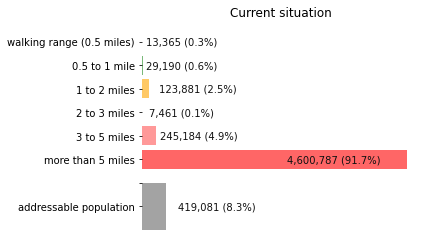

In [398]:
# bar chart of population by distance to bart station
fig, ax = plt.subplots(figsize=(5,4))

ax.barh(
    ['addressable population'], 
    df[df.range!='more than 5 miles'].population.sum(),
    color='#666', alpha=0.6, height=2)
ax.text(df[df.range!='more than 5 miles'].population.sum()*0.9+1.6e6, ['addressable population'],
        '{:,.0f} ({:.1%})'.format(df[df.range!='more than 5 miles'].population.sum(),
                                  df[df.range!='more than 5 miles'].population.sum() / df.population.sum()),
        ha='right', va='center', color='#111')

ax.barh(
    [''], 
    np.nan,
    color='red', alpha=0.6)
    
ax.barh(
    ['more than 5 miles'], 
    df[df.range=='more than 5 miles'].population.sum(),
    color='red', alpha=0.6)
ax.text(df[df.range=='more than 5 miles'].population.sum()*0.9, ['more than 5 miles'],
        '{:,.0f} ({:.1%})'.format(df[df.range=='more than 5 miles'].population.sum(),
                                  df[df.range=='more than 5 miles'].population.sum() / df.population.sum()),
        ha='right', va='center', color='#111')

ax.barh(
    ['3 to 5 miles'], 
    df[df.range=='3 to 5 miles'].population.sum(),
    color='red', alpha=0.4)
ax.text(df[df.range=='3 to 5 miles'].population.sum()*1.3, ['3 to 5 miles'],
        '{:,.0f} ({:.1%})'.format(df[df.range=='3 to 5 miles'].population.sum(),
                                  df[df.range=='3 to 5 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['2 to 3 miles'], 
    df[df.range=='2 to 3 miles'].population.sum(),
    color='#FFA500', alpha=0.8)
ax.text(df[df.range=='2 to 3 miles'].population.sum()*2.5 + 1e5, ['2 to 3 miles'],
        '{:,.0f} ({:.1%})'.format(df[df.range=='2 to 3 miles'].population.sum(),
                                  df[df.range=='2 to 3 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['1 to 2 miles'], 
    df[df.range=='1 to 2 miles'].population.sum(),
    color='#FFA500', alpha=0.6)
ax.text(df[df.range=='1 to 2 miles'].population.sum()*2.4, ['1 to 2 miles'],
        '{:,.0f} ({:.1%})'.format(df[df.range=='1 to 2 miles'].population.sum(),
                                  df[df.range=='1 to 2 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['0.5 to 1 mile'], 
    df[df.range=='0.5 to 1 mile'].population.sum(),
    color='#228B22', alpha=0.6)
ax.text(df[df.range=='0.5 to 1 mile'].population.sum()*2.8, ['0.5 to 1 mile'],
        '{:,.0f} ({:.1%})'.format(df[df.range=='0.5 to 1 mile'].population.sum(),
                                  df[df.range=='0.5 to 1 mile'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['walking range (0.5 miles)'], 
    df[df.range=='walking range (0.5 miles)'].population.sum(),
    color='#228B22', alpha=0.8)
ax.text(df[df.range=='walking range (0.5 miles)'].population.sum() * 0.9 + 13e5, ['walking range (0.5 miles)'],
        '{:,.0f} ({:.1%})'.format(df[df.range=='walking range (0.5 miles)'].population.sum(),
                                  df[df.range=='walking range (0.5 miles)'].population.sum() / df_dist.population.sum()),
        ha='right', va='center', color='#111')

# ax2 = ax.twinx()
# ax2.plot(df_dist_bkl['distance'], df_dist_bkl['rel_cum_population'])
ax.set_title('Current situation')
# ax.set_ylabel('Population')
# ax.set_xlabel('Distance (max miles)')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [389]:
## berkeley + 3

# select number of stores
df = df_distances[df_distances.name.isin(df_select.head(4).name)]

# calculate distance from stations to all zips
def my_calculate_distance_df(row):
    "Given two points in (latitude, longitude) format, calculate the distance between them in miles"
    
    geod = Geodesic.WGS84

    g = geod.Inverse(row['zip_lat'], row['zip_lon'], row['store_lat'], row['store_lon'])
    miles = g['s12'] / 1000 * 0.621371
    
    return miles
df['distance'] = df.apply(my_calculate_distance_df, axis=1)

df['contains_station'] = np.where(df.zip.isin(stations[stations.station.isin(df_select.head(4).name)].zip),1,0)
df.contains_station = np.where(df.zip=='94705',1, df.contains_station) # berkeley store

# get only nearest stations for each zip
df = df.sort_values(by=['distance']).drop_duplicates(subset=['zip'], keep='first')
df['range'] = pd.cut(df['distance'], [0, 0.5, 1,2,3,5, 1e10], labels=['walking range (0.5 miles)','0.5 to 1 mile', '1 to 2 miles', '2 to 3 miles', '3 to 5 miles','more than 5 miles'])
df['range'] = np.where(df.contains_station==1,'walking range (0.5 miles)',df.range)


# get the nearest station
df.sort_values(by='distance', ascending=True, inplace=True)
df.drop_duplicates(subset=['zip'], keep='first')

df.head()

<ipython-input-389-648a6cdb2c93>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(my_calculate_distance_df, axis=1)
<ipython-input-389-648a6cdb2c93>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contains_station'] = np.where(df.zip.isin(stations[stations.station.isin(df_select.head(4).name)].zip),1,0)
/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,name,store_lat,store_lon,zip,zip_lat,zip_lon,population,distance,contains_station,range
242,Orinda,37.878427,-122.183740,94563,37.8797,-122.1846,19341,0.099592,1,walking range (0.5 miles)
351,24th Street Mission,37.752000,-122.418700,94110,37.7500,-122.4154,74161,0.227336,1,walking range (0.5 miles)
604,MacArthur,37.828260,-122.267275,94609,37.8343,-122.2643,22811,0.447226,1,walking range (0.5 miles)
116,Berkeley,37.855500,-122.260400,94704,37.8666,-122.2580,29190,0.776715,0,0.5 to 1 mile
354,24th Street Mission,37.752000,-122.418700,94114,37.7580,-122.4354,34754,1.003721,0,1 to 2 miles


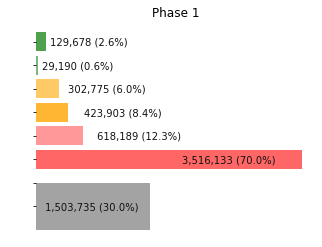

In [390]:
# bar chart of population by distance to bart station
fig, ax = plt.subplots(figsize=(5,4))

ax.barh(
    [' '], 
    df[df.range!='more than 5 miles'].population.sum(),
    color='#666', alpha=0.6, height=2)
ax.text(df[df.range!='more than 5 miles'].population.sum()*0.9, [' '],
        '{:,.0f} ({:.1%})'.format(df[df.range!='more than 5 miles'].population.sum(),
                                  df[df.range!='more than 5 miles'].population.sum() / df.population.sum()),
        ha='right', va='center', color='#111')

ax.barh(
    [''], 
    np.nan,
    color='red', alpha=0.6)
    
ax.barh(
    ['  '], 
    df[df.range=='more than 5 miles'].population.sum(),
    color='red', alpha=0.6)
ax.text(df[df.range=='more than 5 miles'].population.sum()*0.9, ['  '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='more than 5 miles'].population.sum(),
                                  df[df.range=='more than 5 miles'].population.sum() / df.population.sum()),
        ha='right', va='center', color='#111')
ax.barh(
    ['   '], 
    df[df.range=='3 to 5 miles'].population.sum(),
    color='red', alpha=0.4)
ax.text(df[df.range=='3 to 5 miles'].population.sum()*1.3, ['   '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='3 to 5 miles'].population.sum(),
                                  df[df.range=='3 to 5 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['    '], 
    df[df.range=='2 to 3 miles'].population.sum(),
    color='#FFA500', alpha=0.8)
ax.text(df[df.range=='2 to 3 miles'].population.sum()*1.5, ['    '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='2 to 3 miles'].population.sum(),
                                  df[df.range=='2 to 3 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['     '], 
    df[df.range=='1 to 2 miles'].population.sum(),
    color='#FFA500', alpha=0.6)
ax.text(df[df.range=='1 to 2 miles'].population.sum()*1.4, ['     '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='1 to 2 miles'].population.sum(),
                                  df[df.range=='1 to 2 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['      '], 
    df[df.range=='0.5 to 1 mile'].population.sum(),
    color='#228B22', alpha=0.6)
ax.text(df[df.range=='0.5 to 1 mile'].population.sum()*2.5, ['      '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='0.5 to 1 mile'].population.sum(),
                                  df[df.range=='0.5 to 1 mile'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['       '], 
    df[df.range=='walking range (0.5 miles)'].population.sum(),
    color='#228B22', alpha=0.8)
ax.text(df[df.range=='walking range (0.5 miles)'].population.sum() * 0.9 + 11e5, ['       '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='walking range (0.5 miles)'].population.sum(),
                                  df[df.range=='walking range (0.5 miles)'].population.sum() / df_dist.population.sum()),
        ha='right', va='center', color='#111')

# ax2 = ax.twinx()
# ax2.plot(df_dist_bkl['distance'], df_dist_bkl['rel_cum_population'])
ax.set_title('Phase 1')
# ax.set_ylabel('Population')
# ax.set_xlabel('Distance (max miles)')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [391]:
## berkeley + 6

# select number of stores
df = df_distances[df_distances.name.isin(df_select.head(7).name)]

# calculate distance from stations to all zips
def my_calculate_distance_df(row):
    "Given two points in (latitude, longitude) format, calculate the distance between them in miles"
    
    geod = Geodesic.WGS84

    g = geod.Inverse(row['zip_lat'], row['zip_lon'], row['store_lat'], row['store_lon'])
    miles = g['s12'] / 1000 * 0.621371
    
    return miles
df['distance'] = df.apply(my_calculate_distance_df, axis=1)

df['contains_station'] = np.where(df.zip.isin(stations[stations.station.isin(df_select.head(7).name)].zip),1,0)
df.contains_station = np.where(df.zip=='94705',1, df.contains_station) # berkeley store

# get only nearest stations for each zip
df = df.sort_values(by=['distance']).drop_duplicates(subset=['zip'], keep='first')
df['range'] = pd.cut(df['distance'], [0, 0.5, 1,2,3,5, 1e10], labels=['walking range (0.5 miles)','0.5 to 1 mile', '1 to 2 miles', '2 to 3 miles', '3 to 5 miles','more than 5 miles'])
df['range'] = np.where(df.contains_station==1,'walking range (0.5 miles)',df.range)


# get the nearest station
df.sort_values(by='distance', ascending=True, inplace=True)
df.drop_duplicates(subset=['zip'], keep='first')

df.head()

<ipython-input-391-65a31bcff1ae>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(my_calculate_distance_df, axis=1)
<ipython-input-391-65a31bcff1ae>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contains_station'] = np.where(df.zip.isin(stations[stations.station.isin(df_select.head(7).name)].zip),1,0)
/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,name,store_lat,store_lon,zip,zip_lat,zip_lon,population,distance,contains_station,range
729,South Hayward,37.634362,-122.057172,94544,37.6338,-122.0572,79235,0.038789,1,walking range (0.5 miles)
242,Orinda,37.878427,-122.183740,94563,37.8797,-122.1846,19341,0.099592,1,walking range (0.5 miles)
351,24th Street Mission,37.752000,-122.418700,94110,37.7500,-122.4154,74161,0.227336,1,walking range (0.5 miles)
604,MacArthur,37.828260,-122.267275,94609,37.8343,-122.2643,22811,0.447226,1,walking range (0.5 miles)
1080,Bay Fair,37.697000,-122.126500,94578,37.7064,-122.1252,41059,0.652187,0,0.5 to 1 mile


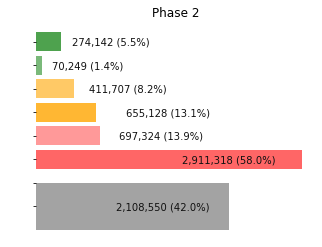

In [394]:
# bar chart of population by distance to bart station
fig, ax = plt.subplots(figsize=(5,4))

ax.barh(
    [' '], 
    df[df.range!='more than 5 miles'].population.sum(),
    color='#666', alpha=0.6, height=2)
ax.text(df[df.range!='more than 5 miles'].population.sum()*0.9, [' '],
        '{:,.0f} ({:.1%})'.format(df[df.range!='more than 5 miles'].population.sum(),
                                  df[df.range!='more than 5 miles'].population.sum() / df.population.sum()),
        ha='right', va='center', color='#111')

ax.barh(
    [''], 
    np.nan,
    color='red', alpha=0.6)
    
ax.barh(
    ['  '], 
    df[df.range=='more than 5 miles'].population.sum(),
    color='red', alpha=0.6)
ax.text(df[df.range=='more than 5 miles'].population.sum()*0.9, ['  '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='more than 5 miles'].population.sum(),
                                  df[df.range=='more than 5 miles'].population.sum() / df.population.sum()),
        ha='right', va='center', color='#111')
ax.barh(
    ['   '], 
    df[df.range=='3 to 5 miles'].population.sum(),
    color='red', alpha=0.4)
ax.text(df[df.range=='3 to 5 miles'].population.sum()*1.3, ['   '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='3 to 5 miles'].population.sum(),
                                  df[df.range=='3 to 5 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['    '], 
    df[df.range=='2 to 3 miles'].population.sum(),
    color='#FFA500', alpha=0.8)
ax.text(df[df.range=='2 to 3 miles'].population.sum()*1.5, ['    '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='2 to 3 miles'].population.sum(),
                                  df[df.range=='2 to 3 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['     '], 
    df[df.range=='1 to 2 miles'].population.sum(),
    color='#FFA500', alpha=0.6)
ax.text(df[df.range=='1 to 2 miles'].population.sum()*1.4, ['     '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='1 to 2 miles'].population.sum(),
                                  df[df.range=='1 to 2 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['      '], 
    df[df.range=='0.5 to 1 mile'].population.sum(),
    color='#228B22', alpha=0.6)
ax.text(df[df.range=='0.5 to 1 mile'].population.sum()*2.5, ['      '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='0.5 to 1 mile'].population.sum(),
                                  df[df.range=='0.5 to 1 mile'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['       '], 
    df[df.range=='walking range (0.5 miles)'].population.sum(),
    color='#228B22', alpha=0.8)
ax.text(df[df.range=='walking range (0.5 miles)'].population.sum() * 0.9 + 10e5, ['       '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='walking range (0.5 miles)'].population.sum(),
                                  df[df.range=='walking range (0.5 miles)'].population.sum() / df_dist.population.sum()),
        ha='right', va='center', color='#111')

# ax2 = ax.twinx()
# ax2.plot(df_dist_bkl['distance'], df_dist_bkl['rel_cum_population'])
ax.set_title('Phase 2')
# ax.set_ylabel('Population')
# ax.set_xlabel('Distance (max miles)')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [395]:
## berkeley + 6

# select number of stores
df = df_distances[df_distances.name.isin(df_select.head(10).name)]

# calculate distance from stations to all zips
def my_calculate_distance_df(row):
    "Given two points in (latitude, longitude) format, calculate the distance between them in miles"
    
    geod = Geodesic.WGS84

    g = geod.Inverse(row['zip_lat'], row['zip_lon'], row['store_lat'], row['store_lon'])
    miles = g['s12'] / 1000 * 0.621371
    
    return miles
df['distance'] = df.apply(my_calculate_distance_df, axis=1)

df['contains_station'] = np.where(df.zip.isin(stations[stations.station.isin(df_select.head(10).name)].zip),1,0)
df.contains_station = np.where(df.zip=='94705',1, df.contains_station) # berkeley store

# get only nearest stations for each zip
df = df.sort_values(by=['distance']).drop_duplicates(subset=['zip'], keep='first')
df['range'] = pd.cut(df['distance'], [0, 0.5, 1,2,3,5, 1e10], labels=['walking range (0.5 miles)','0.5 to 1 mile', '1 to 2 miles', '2 to 3 miles', '3 to 5 miles','more than 5 miles'])
df['range'] = np.where(df.contains_station==1,'walking range (0.5 miles)',df.range)


# get the nearest station
df.sort_values(by='distance', ascending=True, inplace=True)
df.drop_duplicates(subset=['zip'], keep='first')

df.head()

,name,store_lat,store_lon,zip,zip_lat,zip_lon,population,distance,contains_station,range
729,South Hayward,37.634362,-122.057172,94544,37.6338,-122.0572,79235,0.038789,1,walking range (0.5 miles)
242,Orinda,37.878427,-122.183740,94563,37.8797,-122.1846,19341,0.099592,1,walking range (0.5 miles)
351,24th Street Mission,37.752000,-122.418700,94110,37.7500,-122.4154,74161,0.227336,1,walking range (0.5 miles)
604,MacArthur,37.828260,-122.267275,94609,37.8343,-122.2643,22811,0.447226,1,walking range (0.5 miles)
1080,Bay Fair,37.697000,-122.126500,94578,37.7064,-122.1252,41059,0.652187,0,0.5 to 1 mile


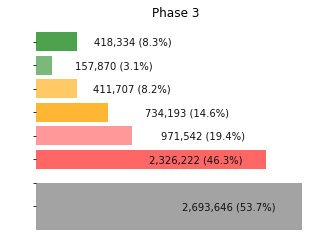

In [396]:
# bar chart of population by distance to bart station
fig, ax = plt.subplots(figsize=(5,4))

ax.barh(
    [' '], 
    df[df.range!='more than 5 miles'].population.sum(),
    color='#666', alpha=0.6, height=2)
ax.text(df[df.range!='more than 5 miles'].population.sum()*0.9, [' '],
        '{:,.0f} ({:.1%})'.format(df[df.range!='more than 5 miles'].population.sum(),
                                  df[df.range!='more than 5 miles'].population.sum() / df.population.sum()),
        ha='right', va='center', color='#111')

ax.barh(
    [''], 
    np.nan,
    color='red', alpha=0.6)
    
ax.barh(
    ['  '], 
    df[df.range=='more than 5 miles'].population.sum(),
    color='red', alpha=0.6)
ax.text(df[df.range=='more than 5 miles'].population.sum()*0.9, ['  '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='more than 5 miles'].population.sum(),
                                  df[df.range=='more than 5 miles'].population.sum() / df.population.sum()),
        ha='right', va='center', color='#111')
ax.barh(
    ['   '], 
    df[df.range=='3 to 5 miles'].population.sum(),
    color='red', alpha=0.4)
ax.text(df[df.range=='3 to 5 miles'].population.sum()*1.3, ['   '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='3 to 5 miles'].population.sum(),
                                  df[df.range=='3 to 5 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['    '], 
    df[df.range=='2 to 3 miles'].population.sum(),
    color='#FFA500', alpha=0.8)
ax.text(df[df.range=='2 to 3 miles'].population.sum()*1.5, ['    '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='2 to 3 miles'].population.sum(),
                                  df[df.range=='2 to 3 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['     '], 
    df[df.range=='1 to 2 miles'].population.sum(),
    color='#FFA500', alpha=0.6)
ax.text(df[df.range=='1 to 2 miles'].population.sum()*1.4, ['     '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='1 to 2 miles'].population.sum(),
                                  df[df.range=='1 to 2 miles'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['      '], 
    df[df.range=='0.5 to 1 mile'].population.sum(),
    color='#228B22', alpha=0.6)
ax.text(df[df.range=='0.5 to 1 mile'].population.sum()*2.5, ['      '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='0.5 to 1 mile'].population.sum(),
                                  df[df.range=='0.5 to 1 mile'].population.sum() / df.population.sum()),
        ha='left', va='center', color='#111')

ax.barh(
    ['       '], 
    df[df.range=='walking range (0.5 miles)'].population.sum(),
    color='#228B22', alpha=0.8)
ax.text(df[df.range=='walking range (0.5 miles)'].population.sum() * 0.9 + 10e5, ['       '],
        '{:,.0f} ({:.1%})'.format(df[df.range=='walking range (0.5 miles)'].population.sum(),
                                  df[df.range=='walking range (0.5 miles)'].population.sum() / df_dist.population.sum()),
        ha='right', va='center', color='#111')

# ax2 = ax.twinx()
# ax2.plot(df_dist_bkl['distance'], df_dist_bkl['rel_cum_population'])
ax.set_title('Phase 3')
# ax.set_ylabel('Population')
# ax.set_xlabel('Distance (max miles)')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()